<div>
    <p style="font-size:30px;"> Digital House - Desafio Final | <img src="https://www.digitalhouse.com/logo-DH.png" align="center" width="300" height="300">  | <img src="crash.jpeg" align="center" width="150" height="150"> </img></p>
</div>

<font color='blue'>
    
Tabla de Contenidos:

1. [Introducción](#intro)
2. [Construcción del dataset](#dataset)
3. [EDA](#eda)
4. [Modelado](#modelado)

<hr>
<div id='intro'>
    <h2> Introducción </h2>
</div>
<hr>

<p>La presente notebook tiene por objetivo el desarrollo del Trabajo Práctico Final Integrador del Grupo 7.

Hoy en día una ambulancia del SAME tarda aproximadamente entre 20 y 30 mínutos en llegar a lugar de un accidente (<a href="https://www.lanacion.com.ar/sociedad/same-una-emergencia-cada-155-minutos-nid1442582/">Referencia</a>). Este tiempo de llegada es en el mejor de los casos cuando la llamada se realiza al 107 y no al 911, como ocurre muchas veces y en el traspaso de la urgencia se pierde todavía más tiempo. Minutos perdidos que podrían ser muy valiosos...
    
La idea de este proyecto es poder predecir la cantidad de accidentes que pueden llegar a haber en una determinada zona de la Ciudad Autónoma de Buenos Aires, considerando distintas variables de las fechas y estado del clima. De esta forma, podrían ubicarse `Spots Ambulatorios` en <b>zonas de mayor riesgo de accidentes de tránsito</b>, llegando a estos lugares con mayor rapidez.
    
Para ello, se elaboró un dataset que fue obtenido de la página del <a href="https://data.buenosaires.gob.ar/dataset/">CABA</a>, junto a otros datos fueron obtenido través de un scrapping realizado sobre la página <a href="https://www.wunderground.com/">Wunderground</a>.</p>

`Imports de librerías necesarias`

In [88]:
import pandas as pd
from datetime import datetime
import re
from datetime import date, datetime, timedelta
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import random
import numpy as np
from datetime import datetime as dt
import shapely.wkt
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#import built_in_functions

%matplotlib inline

<hr>
<div id='dataset'>
    <h2> Construcción del dataset </h2>
</div>
<hr>

<p>Las siguientes celdas constan tanto de <b>lectura</b> como de <b>limpieza</b> de datos para formar el dataset de siniestros viales.

In [2]:
#Importamos DF Siniestros
siniestros_df = pd.read_csv('Victimas_siniestros_2015-2018.csv')

#Convertimos a Geo Points
siniestros_df = gpd.GeoDataFrame(siniestros_df,geometry=gpd.points_from_xy(siniestros_df.x, siniestros_df.y))
#siniestros_df['fecha'] = pd.to_datetime(siniestros_df['fecha'],format='%m/%d/%Y')
siniestros_df.head()

/Users/bpeco/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,causa,rol,tipo,sexo,edad,mes,periodo,fecha,hora,lugar_hecho,...,x,y,geom,cantidad_victimas,comuna,geom_3857,tipo_colision1,participantes_victimas,participantes_acusados,geometry
0,homicidio,conductor,moto,NaN,NaN,2.0,2015,2/14/2015,19:00:00,cafayate y severo garcia grande de zequeira,...,-58.508658,-34.653489,0101000020E610000057E042B51B414DC008419885A553...,1,9.0,0101000020110F0000DE9B958180D858C1EC802966CD68...,motovehiculo - vehiculo,moto,automovil,POINT (-58.50866 -34.65349)
1,homicidio,NaN,NaN,NaN,NaN,2.0,2015,2/25/2015,3:00:00,"lugones, leopoldo av. y udaondo, guillermo av.",...,-58.447680,-34.543513,0101000020E6100000CC4C4C904D394DC0FAF382D99145...,1,13.0,0101000020110F0000BFBC457BDFD158C1E1DDA818C14B...,NaN,NaN,NaN,POINT (-58.44768 -34.54351)
2,homicidio,peaton,peaton,femenino,NaN,2.0,2015,2/27/2015,8:00:00,avda jujuy y avda independencia,...,-58.403516,-34.618839,0101000020E6100000FBC35B67A6334DC03F854E1F364F...,1,3.0,0101000020110F0000F8067D6812CD58C189755F66A55F...,peaton - vehiculo,peaton,"""transporte publico""",POINT (-58.40352 -34.61884)
3,homicidio,NaN,NaN,NaN,NaN,3.0,2015,03-02-15,18:30:00,lavalle 1730,...,-58.391329,-34.603168,0101000020E6100000312FB20D17324DC064587D9E344D...,1,1.0,0101000020110F00005621683DBFCB58C10B59E69B815B...,NaN,NaN,NaN,POINT (-58.39133 -34.60317)
4,homicidio,pasajero,camion,masculino,NaN,4.0,2015,04-09-15,1:20:00,ave salvador m del carril 2434,...,-58.492895,-34.587489,0101000020E61000009BDD7231173F4DC02D782AD7324B...,1,15.0,0101000020110F00006F2F76D4C9D658C1750825735D57...,vehiculo - vehiculo,camion,camion,POINT (-58.49290 -34.58749)


In [3]:
#Importamos DF Barrios
barrios = gpd.read_file("barrios.csv")

In [4]:
def from_wkt(dataframe, wkt_column):
    '''
    Obtiene las coordenadas de una columna WKT.

    Retorna un dataframe igual a `dataframe` con una columna nueva `coordenadas` en la cual se encuentra la columna `wkt_column` en el correcto formato geoespacial.

    Parameters
    ----------
    dataframe : dataframe en el cual se encuentra la columna WKT.

    wkt_column : columna a través de la cual se va a obtener la nueva columna `coordenadas` en formato geoespacial.
    '''


    dataframe["coordenadas"]= dataframe[wkt_column].apply(shapely.wkt.loads)
    geo_barrios = gpd.GeoDataFrame(dataframe, geometry='coordenadas')
    return geo_barrios

In [5]:
# change geometry
barrios = from_wkt(barrios, "WKT")

In [6]:
barrios["WKT"] = barrios["WKT"].apply(shapely.wkt.loads) 
barrios = gpd.GeoDataFrame(barrios, geometry='WKT')
type(barrios)

geopandas.geodataframe.GeoDataFrame

In [7]:
n=0
for index_siniestros, row_siniestros in siniestros_df.iterrows():
    if n in [1000, 5000, 10000, 15000, 25000, 30000]:
        print(n)
    for index_barrios, row_barrios in barrios.iterrows():
        if row_barrios['coordenadas'].contains(row_siniestros['geometry']):
            siniestros_df.loc[n, 'Barrio'] = row_barrios['barrio']
            break
    n+=1

1000
5000
10000
15000
25000
30000


In [9]:
siniestros_df.head(5)

,causa,rol,tipo,sexo,edad,mes,periodo,fecha,hora,lugar_hecho,...,y,geom,cantidad_victimas,comuna,geom_3857,tipo_colision1,participantes_victimas,participantes_acusados,geometry,Barrio
0,homicidio,conductor,moto,NaN,NaN,2.0,2015,2/14/2015,19:00:00,cafayate y severo garcia grande de zequeira,...,-34.653489,0101000020E610000057E042B51B414DC008419885A553...,1,9.0,0101000020110F0000DE9B958180D858C1EC802966CD68...,motovehiculo - vehiculo,moto,automovil,POINT (-58.50866 -34.65349),MATADEROS
1,homicidio,NaN,NaN,NaN,NaN,2.0,2015,2/25/2015,3:00:00,"lugones, leopoldo av. y udaondo, guillermo av.",...,-34.543513,0101000020E6100000CC4C4C904D394DC0FAF382D99145...,1,13.0,0101000020110F0000BFBC457BDFD158C1E1DDA818C14B...,NaN,NaN,NaN,POINT (-58.44768 -34.54351),BELGRANO
2,homicidio,peaton,peaton,femenino,NaN,2.0,2015,2/27/2015,8:00:00,avda jujuy y avda independencia,...,-34.618839,0101000020E6100000FBC35B67A6334DC03F854E1F364F...,1,3.0,0101000020110F0000F8067D6812CD58C189755F66A55F...,peaton - vehiculo,peaton,"""transporte publico""",POINT (-58.40352 -34.61884),BALVANERA
3,homicidio,NaN,NaN,NaN,NaN,3.0,2015,03-02-15,18:30:00,lavalle 1730,...,-34.603168,0101000020E6100000312FB20D17324DC064587D9E344D...,1,1.0,0101000020110F00005621683DBFCB58C10B59E69B815B...,NaN,NaN,NaN,POINT (-58.39133 -34.60317),SAN NICOLAS
4,homicidio,pasajero,camion,masculino,NaN,4.0,2015,04-09-15,1:20:00,ave salvador m del carril 2434,...,-34.587489,0101000020E61000009BDD7231173F4DC02D782AD7324B...,1,15.0,0101000020110F00006F2F76D4C9D658C1750825735D57...,vehiculo - vehiculo,camion,camion,POINT (-58.49290 -34.58749),AGRONOMIA


> Generamos un dataframe con las fechas correspondientes 2015 hasta 2018. Nos va a ser útil más adelante en la notebook para generar el dataset complemento (es decir, cuando no hubieron accidentes).

In [10]:
Dates_combined = pd.date_range(start='1/1/2015', end='05/31/2018', freq = "1 H")
Dates_combined = Dates_combined.format(formatter=lambda x: x.strftime('%Y-%m-%d %H'))
Dates_combined = pd.DataFrame(Dates_combined)
Dates_combined = Dates_combined.rename(columns={0: 'Date'})
Dates_combined['Hour'] = Dates_combined['Date'].apply(lambda x : x.split()[1])

Dates_combined['Date'] = pd.to_datetime(Dates_combined['Date'],format = '%Y-%m-%d')
Dates_combined['Date'] = Dates_combined['Date'].dt.date
Dates_combined['Hour'] = Dates_combined['Hour'].astype(int)
Dates_combined

,Date,Hour
0,2015-01-01,0
1,2015-01-01,1
2,2015-01-01,2
3,2015-01-01,3
4,2015-01-01,4
...,...,...
29900,2018-05-30,20
29901,2018-05-30,21
29902,2018-05-30,22
29903,2018-05-30,23


In [11]:
siniestros_df = siniestros_df.dropna(subset=['fecha', 'mes', 'hora']).reset_index(drop=True)
#siniestros_df = siniestros_df.dropna(subset=['mes'])

In [12]:
#siniestros_df.info()

> Funcion para estandarizar la fecha de una columna


In [13]:
def format_date_in_df(dataset, date_column):
    '''
    Estandariza el formato de una columna fecha con varios formatos.

    Retorna un dataframe igual a `dataset` con una columna nueva `date_columns` estandarizada separando año, mes y día con una "/".

    Parameters
    ----------
    dataframe : dataframe en el cual se encuentra la columna de fecha a estandarizar.

    date_column : columna a través de la cual se va a obtener la nueva columna `fecha_std` en formato estandarizado.
    '''
    
    #1er paso reemplazar los guiones por '/'
    dataset[date_column] = dataset[date_column].apply(lambda f: f.replace('-', '/'))
    
    #2do paso extraer el dia de la columna fecha
    pattern = '/(\d+)/'
    re.compile(pattern, flags=re.IGNORECASE)
    dias = dataset[date_column].apply(lambda f: re.search(pattern, f).groups()[0])
    
    #dataset[date_column] = dataset[date_column].apply(lambda f: '0' + f if f[0] != 0 or (f[:2] != '10' and f[:2] != '11' and f[:2] != '12') else pass)
    
    dataset['dia'] = dias
    
    #3er paso juntar el dia, mes y año con la '/'
    dataset['fecha_std'] = dataset.dia + '/' + dataset.mes.astype(str) + '/' + dataset.periodo.astype(str)
    #display(dataset['dia/mes/periodo'])
    
    #4to paso crear la columna estandarizada
    dataset['fecha_std'] = dataset['fecha_std'].apply(lambda f: datetime.strptime(f, '%d/%m/%Y'))
    
    return dataset

In [14]:
#Reemplazamos los valores nulos por 0
siniestros_df.mes.fillna(value=0., inplace=True)

#Cambiamos el tipo de dato de la columna "mes"
siniestros_df.mes = siniestros_df.mes.astype(int)

In [15]:
#Usamos la función creada para formatear la columna de fecha
siniestros_df = format_date_in_df(siniestros_df, 'fecha')

In [16]:
siniestros_df['solo_hora'] = siniestros_df.hora.apply(lambda h: h.split(':')[0])

In [17]:
#Pasamos a tipo de dato fecha la columna 'fecha_std'
siniestros_df['fecha_std'] = siniestros_df['fecha_std'].dt.date

`Creación del dataset complemento`

Todo lo anterior estaba relacionado a un dataset donde para cada fecha, hora y barrio había una accidente.
Si nos hubiéramos quedado con solo ese dataset, el modelo iba a estar entrenado de forma sesgada con la premisa de que siempre va a haber una accidente, y esto es un error.

Es por ello que lo que continúa es la elaboración del dataset complemento, es decir, fechas, horas y barrios donde no hubieron accidentes.

> La lista que se encuentra a continuación es una "clave" que se formó a través de la concatenación de la fecha, hora y barrio con un guión bajo, de toda aquella fecha_hora_barrio en la que hubo un accidente

In [18]:
fechas_confirm = siniestros_df[['fecha_std', 'solo_hora', 'Barrio']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
fechas_confirm

0          2015-02-14_19_MATADEROS
1            2015-02-25_3_BELGRANO
2           2015-02-27_8_BALVANERA
3        2015-03-02_18_SAN NICOLAS
4           2015-04-09_1_AGRONOMIA
                   ...            
33157            2018-05-30_17_nan
33158    2018-05-31_20_SAN NICOLAS
33159    2018-05-31_9_VILLA CRESPO
33160    2018-05-31_9_VILLA CRESPO
33161      2018-05-31_14_CHACARITA
Length: 33162, dtype: object

> A continuanción se forma la lista con la misma lógica de la "clave" con guión bajo, para toda posible fecha, hora y barrio. Con esta lista lo que estamos suponiendo -a priori- es que en todas estas claves NO hubo un accidente.

In [19]:
Dates_combined['Date_as_DT'] = pd.to_datetime(Dates_combined['Date'])

In [20]:
Dates_combined.head()

,Date,Hour,Date_as_DT
0,2015-01-01,0,2015-01-01
1,2015-01-01,1,2015-01-01
2,2015-01-01,2,2015-01-01
3,2015-01-01,3,2015-01-01
4,2015-01-01,4,2015-01-01


In [21]:
#Dates_combined
date_hour_barrio_df = pd.DataFrame()

In [22]:
n = 0
for index, row in Dates_combined.iterrows():
    for b in barrios.barrio:
        date_hour_barrio_df.loc[n,"Key"] = str(row['Date']) + "_" + str(row['Hour']) + "_" + b
        n+=1
        

In [23]:
date_hour_barrio_df=pd.read_csv('complemento_df.csv').drop("Unnamed: 0", axis=1)
date_hour_barrio_df

,Key_final
0,2015-01-01_0_CHACARITA
1,2015-01-01_0_PATERNAL
2,2015-01-01_0_VILLA CRESPO
3,2015-01-01_0_VILLA DEL PARQUE
4,2015-01-01_0_ALMAGRO
...,...
1435387,2018-05-31_23_BELGRANO
1435388,2018-05-31_23_RECOLETA
1435389,2018-05-31_23_RETIRO
1435390,2018-05-31_23_NUÃ‘EZ


In [ ]:
#NO CORRER
#n=0
#for index, row in data_2015.iterrows():
#    if n in [1000, 2500, 5000, 10000, 50000, 100000, 200000, 300000, 400000]:
#        print(n)
#    texto = row['Key']
#    try:
#        flag = int(texto[10:12])
#        texto = texto[:10]+'_'+texto[10:12]+'_'+texto[12:]
#    except:
#        texto=texto[:10]+'_'+texto[10:11]+'_'+texto[11:]
#    
#    data_2015.loc[n, 'Key_final'] = texto
#    
#    n+=1

> Luego de formar la lista de claves donde todas son asumidas como "no accidentes", guardamos en una lista los índices de las llaves que aparecen en la lista `fechas_confirm` (recordando que esta última lista era la que tenía las "claves" de los registros confirmados con accidentes).
>
> Posteriormente estos índices los removemos de la lista de "no accidentes", por lo que ahora sí esta lista está conformada únicamente por momentos-lugares donde NO hubieron accidentes.

In [24]:
drop_indexes = []
n=0
for index, row in date_hour_barrio_df.iterrows():
    if n in [10000, 50000, 100000, 250000, 500000, 750000, 1000000]:
        print(n)
    if row['Key_final'] in fechas_confirm.values:
        drop_indexes.append(index)

    n+=1
#Dates_combined.drop(drop_indexes, inplace = True)

10000
50000
100000
250000
500000
750000
1000000


In [25]:
date_hour_barrio_df.drop(drop_indexes, inplace = True)

In [26]:
date_hour_barrio_df.reset_index(drop=True, inplace=True)

In [27]:
date_hour_barrio_df.head(2)

,Key_final
0,2015-01-01_0_CHACARITA
1,2015-01-01_0_PATERNAL


In [28]:
date_hour_barrio_df['fecha_std'] = date_hour_barrio_df.Key_final.apply(lambda k: k.split('_')[0])
date_hour_barrio_df['solo_hora'] = date_hour_barrio_df.Key_final.apply(lambda k: k.split('_')[1])
date_hour_barrio_df['Barrio'] = date_hour_barrio_df.Key_final.apply(lambda k: k.split('_')[2])

In [29]:
date_hour_barrio_df.head()

,Key_final,fecha_std,solo_hora,Barrio
0,2015-01-01_0_CHACARITA,2015-01-01,0,CHACARITA
1,2015-01-01_0_PATERNAL,2015-01-01,0,PATERNAL
2,2015-01-01_0_VILLA CRESPO,2015-01-01,0,VILLA CRESPO
3,2015-01-01_0_VILLA DEL PARQUE,2015-01-01,0,VILLA DEL PARQUE
4,2015-01-01_0_ALMAGRO,2015-01-01,0,ALMAGRO


In [30]:
#full_df
#full_df.to_csv('solo_accidentes.csv')

In [31]:
#pd.read_csv('solo_accidentes.csv').drop('Unnamed: 0', axis=1)

In [32]:
#siniestros_df.to_csv('solo_accidentes_v2.csv')

In [33]:
#full_df = pd.read_csv('solo_accidentes.csv').drop('Unnamed: 0', axis=1)

`Unión de dataframe de accidentes y no accidentes`

In [34]:
#Append de Sinistros DF con Dates Combined + Merge con clima
full_df = siniestros_df.append(date_hour_barrio_df.drop('Key_final',axis=1), ignore_index=True)

In [35]:
full_df['fecha_std_datetime'] = full_df['fecha_std'].apply(lambda d: pd.to_datetime(d))

In [36]:
#Creamos una columna que tiene únicamente el dia y el mes
full_df['dia/mes'] = full_df['fecha_std_datetime'].apply(lambda f: str(f.day)+'/'+str(f.month))

In [37]:
full_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1439983 entries, 0 to 1439982
Data columns (total 36 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   causa                         33162 non-null    object        
 1   rol                           32830 non-null    object        
 2   tipo                          32067 non-null    object        
 3   sexo                          32969 non-null    object        
 4   edad                          32610 non-null    float64       
 5   mes                           33162 non-null    float64       
 6   periodo                       33162 non-null    float64       
 7   fecha                         33162 non-null    object        
 8   hora                          33162 non-null    object        
 9   lugar_hecho                   29462 non-null    object        
 10  direccion_normalizada         32403 non-null    object    

In [38]:
full_df.head()

,causa,rol,tipo,sexo,edad,mes,periodo,fecha,hora,lugar_hecho,...,tipo_colision1,participantes_victimas,participantes_acusados,geometry,Barrio,dia,fecha_std,solo_hora,fecha_std_datetime,dia/mes
0,homicidio,conductor,moto,NaN,NaN,2.0,2015.0,2/14/2015,19:00:00,cafayate y severo garcia grande de zequeira,...,motovehiculo - vehiculo,moto,automovil,POINT (-58.50866 -34.65349),MATADEROS,14,2015-02-14,19,2015-02-14,14/2
1,homicidio,NaN,NaN,NaN,NaN,2.0,2015.0,2/25/2015,3:00:00,"lugones, leopoldo av. y udaondo, guillermo av.",...,NaN,NaN,NaN,POINT (-58.44768 -34.54351),BELGRANO,25,2015-02-25,3,2015-02-25,25/2
2,homicidio,peaton,peaton,femenino,NaN,2.0,2015.0,2/27/2015,8:00:00,avda jujuy y avda independencia,...,peaton - vehiculo,peaton,"""transporte publico""",POINT (-58.40352 -34.61884),BALVANERA,27,2015-02-27,8,2015-02-27,27/2
3,homicidio,NaN,NaN,NaN,NaN,3.0,2015.0,03/02/15,18:30:00,lavalle 1730,...,NaN,NaN,NaN,POINT (-58.39133 -34.60317),SAN NICOLAS,02,2015-03-02,18,2015-03-02,2/3
4,homicidio,pasajero,camion,masculino,NaN,4.0,2015.0,04/09/15,1:20:00,ave salvador m del carril 2434,...,vehiculo - vehiculo,camion,camion,POINT (-58.49290 -34.58749),AGRONOMIA,09,2015-04-09,1,2015-04-09,9/4


`Agregado de variables que pueden influir en la ocurrencia de un accidente`

### ==> Variable: Estación del año <==

In [39]:
Y = 2015
estaciones = [('verano', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('otoño', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('invierno', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('primavera', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('verano', (date(Y, 12, 21),  date(Y, 12, 31)))]

In [40]:
def obtener_estacion(fecha):
    '''
    Obteniene la estación del año a la cual pertenece una fecha.

    Parameters
    ----------
    fecha : fecha de la cual se desea conocer la estación.
    '''
    if isinstance(fecha, datetime):
        fecha = fecha.date()
        
    #print(fecha.day==29)
    #print(fecha.month==2)
    if fecha.day == 29 and fecha.month == 2:
        #print(fecha)
        fecha = fecha - timedelta(1)
        #print(fecha)
        
    fecha = fecha.replace(year=Y) #reemplaza cualquier año por el 2015 (o lo definido en la variable Y)
    return next(estacion for estacion, (empieza, termina) in estaciones
                if empieza <= fecha <= termina)


In [41]:
full_df['estacion'] = full_df['fecha_std_datetime'].apply(lambda f: obtener_estacion(f))

### ==> Variable: Fin de semana <==

In [42]:
full_df['dia_semana'] = full_df.fecha_std_datetime.apply(lambda f: f.strftime("%A"))

In [43]:
def get_dummie_day(day):
    '''
    Convierte en dummie dependiendo si una `fecha` es día hábil o no.

    Parameters
    ----------
    day : día del cual se desea obtener la variable dummie.
    '''
    
    if day in ['Saturday', 'Sunday']:
        return 1
    else:
        return 0

In [44]:
full_df['fin_de_semana_dummie'] = full_df['dia_semana'].apply(lambda d: get_dummie_day(d))

In [ ]:
#full_df#[['fecha_std', 'solo_hora', 'dia/mes', 'Barrio', 'estacion', 'fin_de_semana_dummie']]

### ==> Variable: Estado del clima <==

`Levantamos el dataset del clima`

<p>Para obtener esta información, realizamos un scrapping sobre la página <a href="https://www.wunderground.com/">Wunderground</a>.

La base de este scrapping fue obtenido gracias al Profesor Felix Penna. Utilizando dicha .ipynb como apoyo, sumado a algunos cambios que realizamos, logramos sacar la información del clima para cada fecha y hora comprendida entre el 01/01/2015 y el 31/05/2018, dado que la información de siniestros disponible data el mismo rango de fechas. Esta data la guardamos en el csv `info_clima.csv`<br> Sin embargo, hubieron algunas fechas para las cuales la página no devolvía información alguna, por lo que luego estos registros serán descartados.</p>

In [45]:
clima_df = pd.read_csv('info_clima.csv').drop(['Unnamed: 0', 'Rain_Ml'], axis=1)

In [46]:
clima_df.head()

,Date,Hour,AM/PM,Wind_Speed,Condition,Only_Hour,Full_Hour
0,2015-01-01,12:00,AM,2.0,Fair,12,0.0
1,2015-01-01,1:00,AM,2.0,Fair,1,1.0
2,2015-01-01,2:00,AM,7.0,Mostly Cloudy,2,2.0
3,2015-01-01,3:00,AM,9.0,Fair,3,3.0
4,2015-01-01,4:00,AM,7.0,Fair,4,4.0


> La columna "Condition" del dataset de clima contiene información sobre cómo estaba el clima en general ese día. Dada la variedad de distintas respuestas, y considerando que esta es una variable que posteriormente va a ser "dummificada", para reducir la dimensionalidad del dataset, homogeneizamos las respuestas. Es por ello que creamos el diccionario map_weather.

In [47]:
#Disminuimos la cantidad de valores en Condition
map_weather = {'Fair / Windy':"Windy",
'Fair':"Fair",
'Partly Cloudy':"Cloudy",
'Mostly Cloudy':"Cloudy",
'Cloudy':"Cloudy",
'Drizzle':"Drizzle",
'Thunder':"Storm",
'Light Rain with Thunder':"Storm",
'T-Storm':"Storm",
'Fog':"Fog",
'Rain Shower':"Rain",
'Cloudy / Windy':"Windy",
'Light Rain':"Rain",
'Rain':"Rain",
'Heavy Rain':"Rain",
'Rain Shower / Windy':"Rain",
'Mostly Cloudy / Windy':"Cloudy",
'Shallow Fog':"Fog",
'Light Drizzle':"Drizzle",
'Haze':"Fog",
 'Partly Cloudy / Windy':"Windy",
 'Heavy T-Storm':"Storm",
 'Smoke':"Fog",
 'Heavy Rain Shower':"Rain",
 'Thunder in the Vicinity':"Storm",
 'Drizzle and Fog':"Fog",
 'Rain / Windy':"Rain",
 'Mist':"Fog",
 'Light Rain / Windy':"Rain",
 'T-Storm / Windy':"Storm",
 'Heavy T-Storm / Windy':"Storm",
 'Low Drifting Dust':"Fog",
 'Thunder and Hail':"Storm",
 'Thunder and Hail /':"Storm",
 'Heavy Drizzle':"Drizzle",
 'Heavy Drizzle / Windy':"Drizzle",
 'Drizzle / Windy':"Drizzle",
 'Volcanic Ash':"Volcanic Ash",
 'Light Drizzle / Windy':"Windy",
 'Showers in the Vicinity':"Rain",
 'Light Rain Shower':"Rain",
 'Thunder / Windy':"Storm",
 'Duststorm':"Storm"}

In [48]:
clima_df['Condition'] = clima_df['Condition'].map(map_weather)

In [49]:
clima_df['Date'] = pd.to_datetime(clima_df['Date'])

In [50]:
clima_df['Full_Hour'] = clima_df['Full_Hour'].astype(int)

In [51]:
full_df['solo_hora']=full_df['solo_hora'].astype(int)

`Juntamos la información de accidentes y no accidentes con la de clima`

In [52]:
final_df = full_df.merge(clima_df, left_on=['fecha_std_datetime', 'solo_hora'], right_on=['Date', 'Full_Hour'], how='left')#.drop_duplicates()

> Descartamos los registros en los cuales falta la información del clima

In [53]:
final_df = final_df[(final_df['Wind_Speed'].notnull())]

In [54]:
final_df.head()

,causa,rol,tipo,sexo,edad,mes,periodo,fecha,hora,lugar_hecho,...,estacion,dia_semana,fin_de_semana_dummie,Date,Hour,AM/PM,Wind_Speed,Condition,Only_Hour,Full_Hour
0,homicidio,conductor,moto,NaN,NaN,2.0,2015.0,2/14/2015,19:00:00,cafayate y severo garcia grande de zequeira,...,verano,Saturday,1,2015-02-14,7:00,PM,33.0,Windy,7.0,19.0
1,homicidio,NaN,NaN,NaN,NaN,2.0,2015.0,2/25/2015,3:00:00,"lugones, leopoldo av. y udaondo, guillermo av.",...,verano,Wednesday,0,2015-02-25,3:00,AM,24.0,Fair,3.0,3.0
2,homicidio,peaton,peaton,femenino,NaN,2.0,2015.0,2/27/2015,8:00:00,avda jujuy y avda independencia,...,verano,Friday,0,2015-02-27,8:00,AM,20.0,Cloudy,8.0,8.0
3,homicidio,NaN,NaN,NaN,NaN,3.0,2015.0,03/02/15,18:30:00,lavalle 1730,...,verano,Monday,0,2015-03-02,6:00,PM,13.0,Fair,6.0,18.0
4,homicidio,pasajero,camion,masculino,NaN,4.0,2015.0,04/09/15,1:20:00,ave salvador m del carril 2434,...,otoño,Thursday,0,2015-04-09,1:00,AM,13.0,Fair,1.0,1.0


`Levantamos la información de días feriados`

In [55]:
feriados= pd.read_csv('Feriados_15-18.csv',delimiter=";")

In [56]:
feriados = feriados[feriados['FECHA']<='2018-05-31']

In [57]:
feriados['FECHA'] = pd.to_datetime(feriados['FECHA'], format="%d/%m/%Y")

Se la agregamos al dataset de accidentes y no accidentes

In [58]:
final_df=pd.merge(final_df,feriados,how='left', left_on="fecha_std_datetime", right_on="FECHA")

In [59]:
final_df=final_df.drop(['FECHA'],axis=1)

In [60]:
final_df['FERIADO'].fillna(0, inplace=True)

In [61]:
final_df.head(2)

,causa,rol,tipo,sexo,edad,mes,periodo,fecha,hora,lugar_hecho,...,dia_semana,fin_de_semana_dummie,Date,Hour,AM/PM,Wind_Speed,Condition,Only_Hour,Full_Hour,FERIADO
0,homicidio,conductor,moto,NaN,NaN,2.0,2015.0,2/14/2015,19:00:00,cafayate y severo garcia grande de zequeira,...,Saturday,1,2015-02-14,7:00,PM,33.0,Windy,7.0,19.0,0.0
1,homicidio,NaN,NaN,NaN,NaN,2.0,2015.0,2/25/2015,3:00:00,"lugones, leopoldo av. y udaondo, guillermo av.",...,Wednesday,0,2015-02-25,3:00,AM,24.0,Fair,3.0,3.0,0.0


`Agrupamos por hora, estación del año, lugar y estado del clima`

In [62]:
#La columna 'causa' nunca va está vacía, por lo que quedandonos con esa columna, nos aseguramos contar los registros bien
grouped_df = pd.DataFrame(final_df.groupby(['solo_hora', 'Barrio', 'estacion', 'fin_de_semana_dummie', 'FERIADO', 'Condition']).count().causa.reset_index())#.to_csv('prueba.csv')

In [63]:
grouped_df.rename(columns={'causa': 'cantidad_accidentes'}, inplace=True)#.sort_values('causa', ascending=False)

In [65]:
grouped_df.head()

,solo_hora,Barrio,estacion,fin_de_semana_dummie,FERIADO,Condition,cantidad_accidentes
0,0,AGRONOMIA,invierno,0,0.0,Cloudy,0
1,0,AGRONOMIA,invierno,0,0.0,Drizzle,0
2,0,AGRONOMIA,invierno,0,0.0,Fair,0
3,0,AGRONOMIA,invierno,0,0.0,Fog,0
4,0,AGRONOMIA,invierno,0,0.0,Rain,0


In [66]:
grouped_dummie_df = pd.get_dummies(grouped_df.drop(['cantidad_accidentes'], axis=1).astype(str))

In [67]:
#groued_dummie_df['dia/mes'] = grouped_df['dia/mes']
grouped_dummie_df['cantidad_accidentes'] = grouped_df['cantidad_accidentes']

In [68]:
grouped_dummie_df

,solo_hora_0,solo_hora_1,solo_hora_10,solo_hora_11,solo_hora_12,solo_hora_13,solo_hora_14,solo_hora_15,solo_hora_16,solo_hora_17,...,FERIADO_1.0,Condition_Cloudy,Condition_Drizzle,Condition_Fair,Condition_Fog,Condition_Rain,Condition_Storm,Condition_Volcanic Ash,Condition_Windy,cantidad_accidentes
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
53703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
53704,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
53705,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [69]:
data_model_df = grouped_dummie_df.copy()

`Guardamos el dataset que utilizaremos para modelar en un .csv`

In [71]:
#data_model_df = pd.read_csv('dataset_for_model.csv')

In [72]:
data_model_df.to_csv('dataset_for_model_VFinal.csv', index=False)

In [ ]:
#full_df[full_df.comuna.isnull()]

<hr>
<div id='eda'>
    <h2> EDA </h2>
</div>
<hr>

In [73]:
data_eda = final_df.copy()#pd.read_csv('final_df.csv').drop('Unnamed: 0', axis=1)

In [78]:
data_eda.head(3)

,causa,rol,tipo,sexo,edad,mes,periodo,fecha,hora,lugar_hecho,...,dia_semana,fin_de_semana_dummie,Date,Hour,AM/PM,Wind_Speed,Condition,Only_Hour,Full_Hour,FERIADO
0,homicidio,conductor,moto,NaN,NaN,2.0,2015.0,2/14/2015,19:00:00,cafayate y severo garcia grande de zequeira,...,Saturday,1,2015-02-14,7:00,PM,33.0,Windy,7.0,19.0,0.0
1,homicidio,NaN,NaN,NaN,NaN,2.0,2015.0,2/25/2015,3:00:00,"lugones, leopoldo av. y udaondo, guillermo av.",...,Wednesday,0,2015-02-25,3:00,AM,24.0,Fair,3.0,3.0,0.0
2,homicidio,peaton,peaton,femenino,NaN,2.0,2015.0,2/27/2015,8:00:00,avda jujuy y avda independencia,...,Friday,0,2015-02-27,8:00,AM,20.0,Cloudy,8.0,8.0,0.0


In [79]:
#Chequeo de Valores Nulos
#Función para calcular el porcentaje de valores nulos de un dataframe
def get_percentages_null_values(df):
    '''
    Obtiene los porcentajes de valores nulos de todas las columnas de un `df`.

    Parameters
    ----------
    df : dataframe del cual se desea conocer los porcentajes de nulos por columna
    '''
    
    null_values_info = df.apply(lambda x: x.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)
    display(null_values_info)

In [80]:
solo_accidentes = data_eda[data_eda['causa'].notnull()]

In [81]:
get_percentages_null_values(solo_accidentes)

altura                          78.301942
codigo_cruce                    56.703632
codigo_calle                    51.305521
calle2                          25.019069
lugar_hecho                     21.387080
tipo_colision1                   3.561580
tipo                             3.209529
comuna                           3.191926
Barrio                           3.186059
x                                3.186059
y                                3.186059
geom                             3.186059
geom_3857                        3.186059
geocodificacion                  3.186059
participantes_victimas           2.775333
direccion_normalizada_arcgis     2.405680
calle1                           2.382210
direccion_normalizada            2.382210
edad                             2.188582
rol                              1.496215
participantes_acusados           1.402335
sexo                             0.891862
tipo_calle                       0.000000
hora                             0

In [82]:
data_eda_null_info = pd.DataFrame(solo_accidentes.count(), columns=['Non-Null Count'])

data_eda_null_info['Dtype'] = solo_accidentes.dtypes

In [83]:
cantidad_registros_totales = len(solo_accidentes['estacion'])
cantidad_registros_totales

17043

In [84]:
data_eda_null_info['Percentage Full'] = 100-(data_eda_null_info['Non-Null Count']/cantidad_registros_totales*100)

data_eda_null_info.sort_values(by='Percentage Full', ascending=False, inplace=True)

data_eda_null_info.head()

,Non-Null Count,Dtype,Percentage Full
altura,3698,float64,78.301942
codigo_cruce,7379,float64,56.703632
codigo_calle,8299,float64,51.305521
calle2,12779,object,25.019069
lugar_hecho,13398,object,21.387080


In [85]:
empties_in_final_df_agrupado = data_eda_null_info[data_eda_null_info['Percentage Full'] >= 0.0]

In [86]:
clrs=[]
for x in empties_in_final_df_agrupado['Percentage Full']:
    if x > 60:
        clrs.append('#C70039')
    elif x > 20:
        clrs.append('#FF5733')
    elif x > 10:
        clrs.append('#FFC300')
    else:
        clrs.append('#DAF7A6')

Text(0.7, 0.95, 'Figura 1.\n Distribución de variables nulas en el dataset')

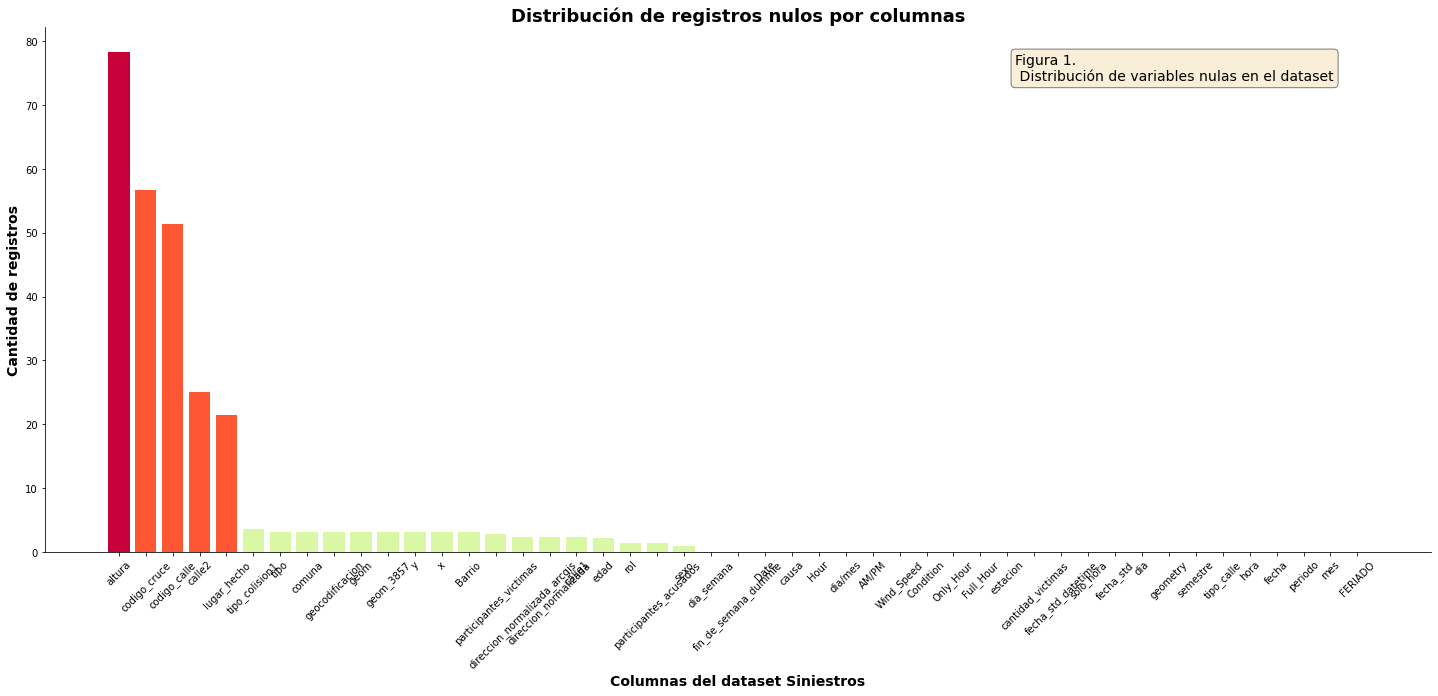

In [87]:
fig, ax = plt.subplots(figsize=(20,8))
#plt.rcParams.update({'font.size': 14})
plt.xticks(rotation=45)
plt.tight_layout()
ax.set_title('Distribución de registros nulos por columnas', fontweight='bold', fontsize=18)
ax.set_xlabel('Columnas del dataset Siniestros', fontweight='bold', fontsize=14)
ax.set_ylabel('Cantidad de registros', fontweight='bold', fontsize=14)
#ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax.bar(empties_in_final_df_agrupado.index, empties_in_final_df_agrupado['Percentage Full'], data=empties_in_final_df_agrupado, color=clrs)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(0.7, 0.95, 'Figura 1.\n Distribución de variables nulas en el dataset', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox= dict(boxstyle='round', facecolor='wheat', alpha=0.5))
#ax.set_xticklabels(info_properatti_df.index, rotation=45)
#plt.savefig('datos_nulos')


In [90]:
siniestros_df['solo_hora'] = siniestros_df['solo_hora'].astype(int)

In [91]:
def plot_variable_years(years_list, dataframe, column_groupby, column_count, title, x_axis_title, y_axis_title, kind='Normal', shareX_option=False, shareY_opcion=True):
    '''
    Grafica una cantidad de visualizaciones según la cantidad de años y las variables utilizadas.
    
    Parameters
    ----------
    years_list : debe ser una lista con los años a través de los cuales se desea graficar. Dependiendo de la longitud de `years_list` va a cambiar la cantidad de gráficos logrados.
    
    dataframe : datos a partir del cual se van a agrupar y contar los datos.
    
    column_groupby : columna por la cual se desea agrupar.
    
    column_count : columna que sea desea contar.
    
    title : titulo del gráfico. Si no se pasa como dato, la visualización no tendrá título.
    
    x_axis_title : título del eje X. Si no se pasa como dato, cada gráfico no tendrá su correspondiente título para el eje x.
    
    y_axis_title : título del eje Y. Si no se pasa como dato, cada gráfico no tendrá su correspondiente título para el eje y.
    
    kind : `plot_variable_years` permite graficar 2 tipos de visualizaciones: barras o geoespacial. Si se omite, se utilizará por defecto `Normal` y se graficarán barras; de lo contrario se graficarán -de ser posible-, los datos geoespaciales.
    '''
    
    
    fig, axes = plt.subplots(2, 2, figsize=(15,10), sharex=False, sharey=True)
    fig.suptitle(title, fontsize='18')
    i=0
    j=0
    for y in years_list:
        acc_year = dataframe[dataframe.periodo==y]
        if kind != 'Geo':
            df = pd.DataFrame(acc_year.groupby(column_groupby)[column_count].count()).reset_index()
        else:
            acc_barrios = acc_year.groupby('Barrio').causa.count().sort_values(ascending=False)
            acc_barrios = barrios.merge(acc_barrios, how='left', left_on='barrio', right_on=acc_barrios.index)
        #print(y)
        #display(df.head(2))
        if y == years_list[0]:
            i=0
            j=0
        elif y == years_list[1]:
            i=0
            j=1
        elif y == years_list[2]:
            i=1
            j=0
        else:
            i=1
            j=1
        #print(i, j)
        if kind != 'Geo':
            sns.barplot(x=column_groupby, y=column_count,data=df, ax=axes[i, j])
        else:
            acc_barrios.plot('causa', figsize=(10,10), legend=True, ax=axes[i,j], vmin=0, vmax=800)

    
        
        axes[i, j].set_title(y)
        axes[i, j].set_xlabel(x_axis_title)
        axes[i, j].set_ylabel(y_axis_title)
        axes[1,1].text(0.3, 0.9, '*Información del año incompleta', horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes)
    
    
    plt.show()


> Vemos en el siguiente gráfico que muestra la `Distribución de accidentes por DÍA para cada año`, que los días no son una variable que aporten valor a la cantidad de accidentes. Por ende, es probable que esta variable sea removida para modelar.

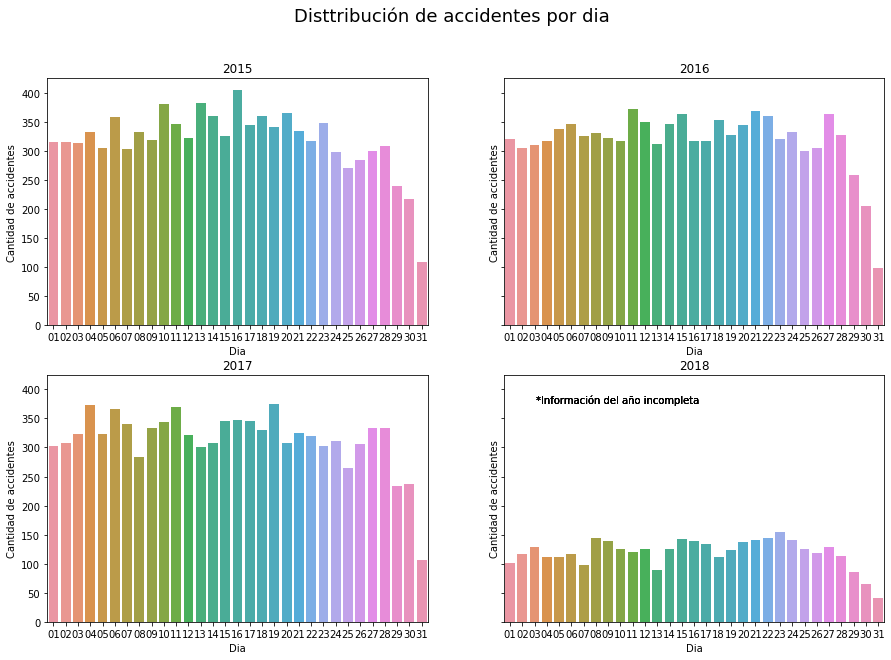

In [92]:
plot_variable_years(list(siniestros_df.periodo.unique()), siniestros_df, 'dia', 'causa', 'Disttribución de accidentes por dia',\
                    'Dia', 'Cantidad de accidentes', kind='Normal')

> A diferencia de la anterior visualización, en el siguiente gráfico que muestra la `Distribución de accidentes por HORA para cada año`, esta variable sí influye en la cantidad de accidentes. 

> Hay una clara tendencia a lo largo de los años que la cantidad de accidentes sub cerca del mediodía, teniendo picos por las tardes.

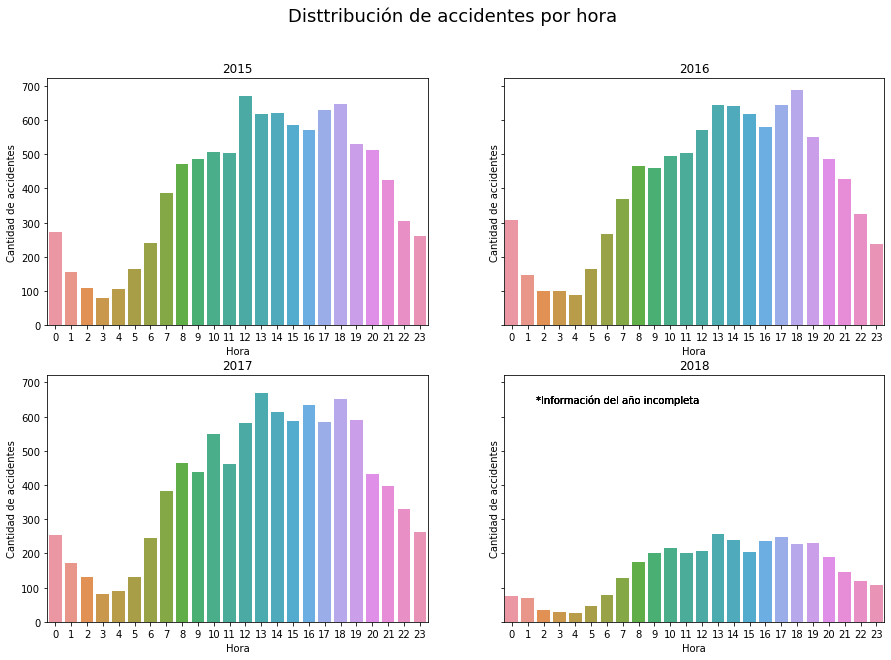

In [93]:
plot_variable_years(list(siniestros_df.periodo.unique()), siniestros_df, 'solo_hora', 'causa', 'Disttribución de accidentes por hora',\
                    'Hora', 'Cantidad de accidentes', kind='Normal')

> Vemos en el siguiente gráfico que muestra la `Distribución de accidentes por MES para cada año`, al igual que los "días" no es una variable que incluye en la cantidad de accidentes. Por ende, es probable que los mismos sean removidos para modelar.

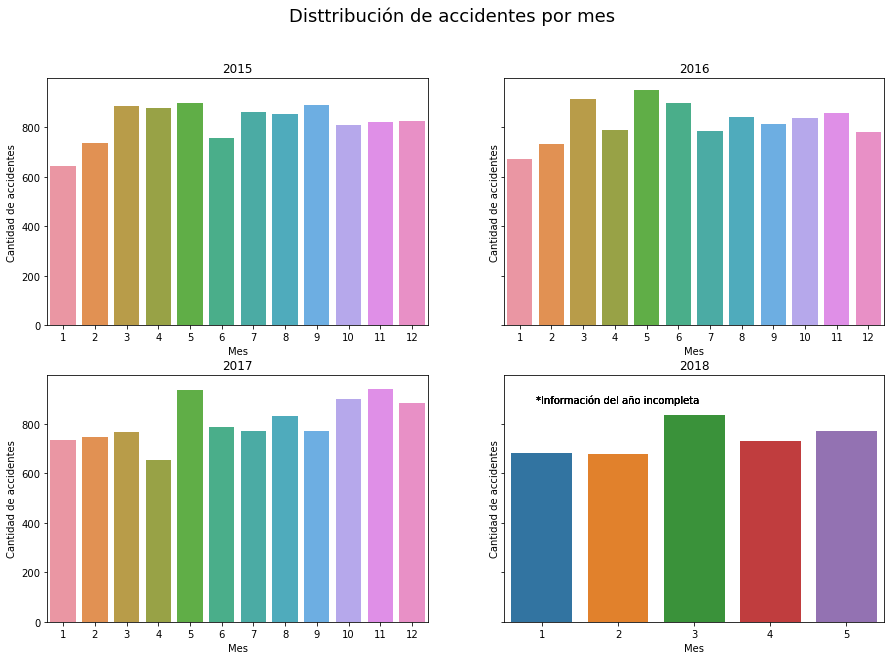

In [94]:
plot_variable_years(list(siniestros_df.periodo.unique()), siniestros_df, 'mes', 'causa', 'Disttribución de accidentes por mes',\
                    'Mes', 'Cantidad de accidentes', kind='Normal')

Text(0.5, 1.0, 'Cantidad de accidente por estación')

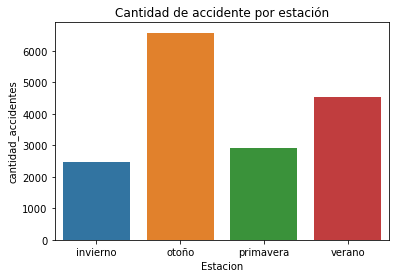

In [95]:
grouped_final_df_agrupado = pd.DataFrame(grouped_df.groupby(['estacion']).sum()['cantidad_accidentes'])
Estacion=grouped_final_df_agrupado.index.values.tolist()
grouped_final_df_agrupado['Estacion']=Estacion
fig, ax=plt.subplots()
sns.barplot(x='Estacion',y='cantidad_accidentes',data=grouped_final_df_agrupado, ax=ax)
ax.set_title('Cantidad de accidente por estación')

> En la siguiente visualización se puede ver cómo la localización influye en la cantidad de accidentes. Los barrios Palermo, Flores, Recoleta es donde ocurren a lo largo de los años mayor cantidad de accidentes.

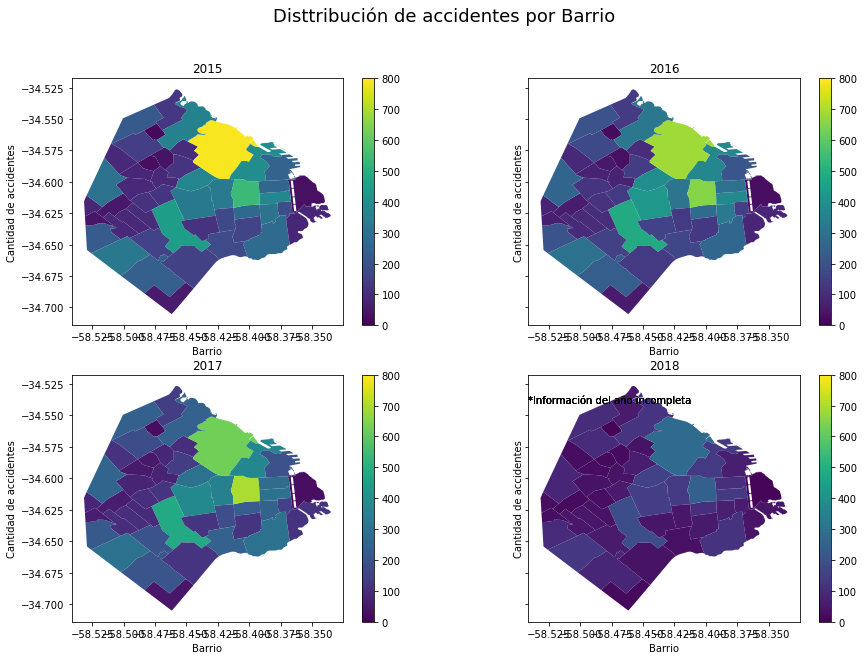

In [96]:
plot_variable_years(list(siniestros_df.periodo.unique()), siniestros_df, 'Barrio', 'causa', 'Disttribución de accidentes por Barrio',\
                    'Barrio', 'Cantidad de accidentes', kind='Geo')

In [97]:
feriados['FECHA_std'] = feriados['FECHA'].apply(lambda f: pd.to_datetime(f))

In [98]:
siniestros_df['fecha_std'] = siniestros_df['fecha_std'].apply(lambda f: pd.to_datetime(f))

In [99]:
feriados.head()

,FECHA,FERIADO,FECHA_std
0,2015-01-01,1,2015-01-01
1,2016-01-01,1,2016-01-01
2,2017-01-01,1,2017-01-01
3,2018-01-01,1,2018-01-01
8,2015-04-02,1,2015-04-02


In [100]:
siniestros_df.head()

,causa,rol,tipo,sexo,edad,mes,periodo,fecha,hora,lugar_hecho,...,comuna,geom_3857,tipo_colision1,participantes_victimas,participantes_acusados,geometry,Barrio,dia,fecha_std,solo_hora
0,homicidio,conductor,moto,NaN,NaN,2,2015,2/14/2015,19:00:00,cafayate y severo garcia grande de zequeira,...,9.0,0101000020110F0000DE9B958180D858C1EC802966CD68...,motovehiculo - vehiculo,moto,automovil,POINT (-58.50866 -34.65349),MATADEROS,14,2015-02-14,19
1,homicidio,NaN,NaN,NaN,NaN,2,2015,2/25/2015,3:00:00,"lugones, leopoldo av. y udaondo, guillermo av.",...,13.0,0101000020110F0000BFBC457BDFD158C1E1DDA818C14B...,NaN,NaN,NaN,POINT (-58.44768 -34.54351),BELGRANO,25,2015-02-25,3
2,homicidio,peaton,peaton,femenino,NaN,2,2015,2/27/2015,8:00:00,avda jujuy y avda independencia,...,3.0,0101000020110F0000F8067D6812CD58C189755F66A55F...,peaton - vehiculo,peaton,"""transporte publico""",POINT (-58.40352 -34.61884),BALVANERA,27,2015-02-27,8
3,homicidio,NaN,NaN,NaN,NaN,3,2015,03/02/15,18:30:00,lavalle 1730,...,1.0,0101000020110F00005621683DBFCB58C10B59E69B815B...,NaN,NaN,NaN,POINT (-58.39133 -34.60317),SAN NICOLAS,02,2015-03-02,18
4,homicidio,pasajero,camion,masculino,NaN,4,2015,04/09/15,1:20:00,ave salvador m del carril 2434,...,15.0,0101000020110F00006F2F76D4C9D658C1750825735D57...,vehiculo - vehiculo,camion,camion,POINT (-58.49290 -34.58749),AGRONOMIA,09,2015-04-09,1


In [101]:
siniestros_feriados=pd.merge(siniestros_df,feriados,how='left', left_on="fecha_std", right_on="FECHA_std")

In [102]:
siniestros_feriados['feriado_dummie'] = siniestros_feriados.FERIADO.apply(lambda f: 0 if pd.isna(f) else 1)

In [103]:
cantidad_no_feriados = len(siniestros_feriados[siniestros_feriados['feriado_dummie']==0].fecha_std.unique())
cantidad_feriados = len(siniestros_feriados[siniestros_feriados['feriado_dummie']==1].fecha_std.unique())

In [104]:
print('Cantidad No Feriados -->', cantidad_no_feriados)
print('Cantidad Feriados -->', cantidad_feriados)

Cantidad No Feriados --> 1223
Cantidad Feriados --> 24


In [105]:
siniestros_feriados=siniestros_feriados.feriado_dummie.value_counts()
siniestros_feriados

0    32744
1      418
Name: feriado_dummie, dtype: int64

In [106]:
print('Ratio Accidentes dia habil -->', siniestros_feriados.iloc[0]/cantidad_no_feriados)
print('Ratio Accidentes dia feriado -->', siniestros_feriados.iloc[1]/cantidad_feriados)
ratios=[siniestros_feriados.iloc[0]/cantidad_no_feriados,siniestros_feriados.iloc[1]/cantidad_feriados ]

Ratio Accidentes dia habil --> 26.77350776778414
Ratio Accidentes dia feriado --> 17.416666666666668


Text(0.5, 1.0, 'Ratio de accidentes según tipo de día')

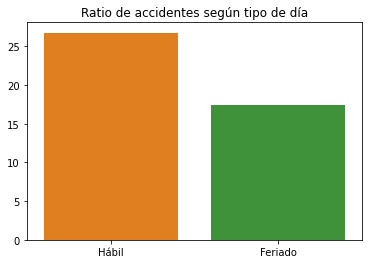

In [107]:
fig, ax = plt.subplots()
sns.barplot(x=['Hábil', 'Feriado'],y=ratios, ax=ax, palette='Paired_r')
ax.set_title("Ratio de accidentes según tipo de día")

<AxesSubplot:title={'center':'Cantidad de `genero` fallecidos'}, xlabel='index', ylabel='sexo'>

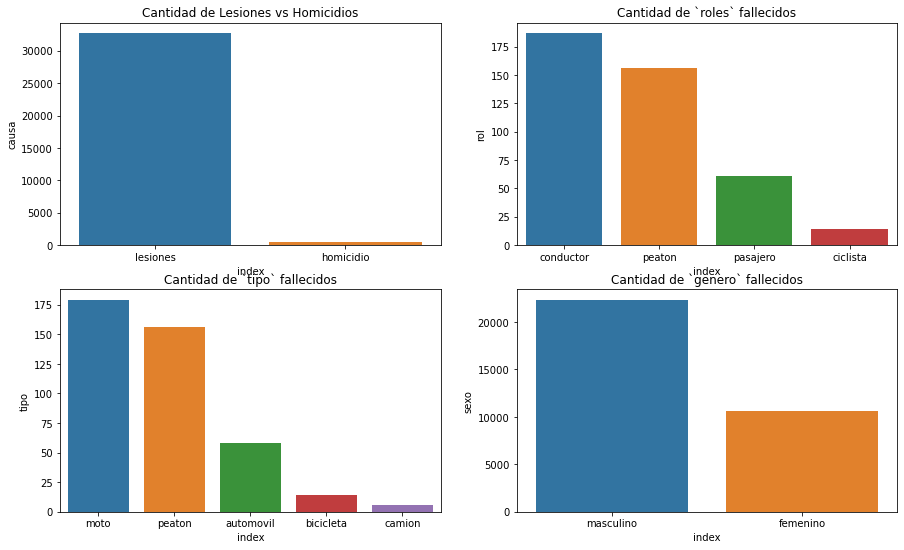

In [109]:
fig, ax = plt.subplots(2,2, figsize=(15,9))
causas_count = siniestros_df.causa.value_counts().reset_index()
ax[0,0].set_title('Cantidad de Lesiones vs Homicidios')
sns.barplot(x=causas_count['index'], y=causas_count['causa'], data=causas_count, ax=ax[0,0])

roles_count = siniestros_df[siniestros_df.causa=='homicidio'].rol.value_counts().reset_index()
roles_count=roles_count[roles_count['index'].isin(['conductor', 'peaton', 'pasajero', 'ciclista'])]
ax[0,1].set_title('Cantidad de `roles` fallecidos')
sns.barplot(x=roles_count['index'], y=roles_count['rol'], data=roles_count, ax=ax[0,1])

tipos_count=siniestros_df[siniestros_df.causa=='homicidio'].tipo.value_counts().reset_index()
tipos_count=tipos_count[tipos_count['tipo']>3]
ax[1,0].set_title('Cantidad de `tipo` fallecidos')
sns.barplot(x=tipos_count['index'], y=tipos_count['tipo'], data=tipos_count, ax=ax[1,0])


sexo_count = siniestros_df.sexo.value_counts().reset_index()
ax[1,1].set_title('Cantidad de `genero` fallecidos')
sns.barplot(x=sexo_count['index'], y=sexo_count['sexo'], data=sexo_count, ax=ax[1,1])

<hr>
<div id='modelado'>
    <h2> Modelado </h2>
</div>
<hr>

El primer paso de nuestro modelado va a ser entrenar 5 modelos de regresión "simples", sin modificar sus hiperparámetros:

* LinearRegression
* KNeighborsRegressor
* DecisionTreeRegressor
* AdaBoostRegressor
* GradientBoostingRegressor

Luego de entrenar cada modelo, lo que vamos a realizar es un Grid Search + Cross Validation sobre cada modelo base, para encontrar la mejor performance de cada modelo y así quedarnos el mejor.

In [2]:
data_model_df=pd.read_csv('dataset_for_model_VFinal.csv')

In [3]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
X = data_model_df.drop('cantidad_accidentes', axis=1)
y = data_model_df.cantidad_accidentes

In [5]:
print(X.shape)
print(y.shape)

(53707, 89)
(53707,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [116]:
print('Shapes en train')
print('X_train --> ',X_train.shape)
print('y_train --> ',y_train.shape,'\n')
print('Shapes en test')
print('X_test --> ',X_test.shape)
print('y_test --> ',y_test.shape)

Shapes en train
X_train -->  (40280, 89)
y_train -->  (40280,) 

Shapes en test
X_test -->  (13427, 89)
y_test -->  (13427,)


In [117]:
xgboost_simple = GradientBoostingRegressor()
adaboost_simple = AdaBoostRegressor()
linear_simple = LinearRegression()
knn_simple = KNeighborsRegressor()
tree_simple = DecisionTreeRegressor()

In [118]:
simple_models = [knn_simple, linear_simple, tree_simple, xgboost_simple, adaboost_simple]

In [119]:
simple_results = {}

In [120]:
for model in simple_models:
    print('======'+str(model)+'======')
        
    print('Fiteando ', str(model), '...')
    model.fit(X_train, y_train)
    print(model, 'fiteado!')
    
    print('Realizando predicciones de ', str(model), '...')
    y_pred = model.predict(X_test)
    print('Predicciones para ', str(model), 'realizadas')
    
    mse = mean_squared_error(y_test, y_pred)
    r2score = r2_score(y_test, y_pred)
    
    model_scores = {'R^2 Score': r2score, 'MSE Score': mse}
    
    print('MSE de '+str(model)+' es de: ', mse)
    print('R^2 de '+str(model)+' es de: ', r2score)
    
    model_dict = {str(model): model_scores}
    
    simple_results.update(model_dict)
    
    #simple_results[str(model)]['R^2 Score'] = r2score
    #simple_results[str(model)]['MSE Score'] = mse
        
    print('\n-----------\n')

======KNeighborsRegressor()======
Fiteando  KNeighborsRegressor() ...
KNeighborsRegressor() fiteado!
Realizando predicciones de  KNeighborsRegressor() ...
Predicciones para  KNeighborsRegressor() realizadas
MSE de KNeighborsRegressor() es de:  0.7255678856036345
R^2 de KNeighborsRegressor() es de:  0.3022825736462387

-----------

======LinearRegression()======
Fiteando  LinearRegression() ...
LinearRegression() fiteado!
Realizando predicciones de  LinearRegression() ...
Predicciones para  LinearRegression() realizadas
MSE de LinearRegression() es de:  0.7884816199356867
R^2 de LinearRegression() es de:  0.24178374276986314

-----------

======DecisionTreeRegressor()======
Fiteando  DecisionTreeRegressor() ...
DecisionTreeRegressor() fiteado!
Realizando predicciones de  DecisionTreeRegressor() ...
Predicciones para  DecisionTreeRegressor() realizadas
MSE de DecisionTreeRegressor() es de:  0.9046696953898861
R^2 de DecisionTreeRegressor() es de:  0.13005547228355618

-----------

======

In [121]:
simple_models_df = pd.DataFrame(simple_results).transpose().sort_values(by='R^2 Score', ascending=False)

In [122]:
simple_models_df

,R^2 Score,MSE Score
GradientBoostingRegressor(),0.355022,0.670723
KNeighborsRegressor(),0.302283,0.725568
LinearRegression(),0.241784,0.788482
DecisionTreeRegressor(),0.130055,0.904670
AdaBoostRegressor(),-0.064729,1.107229


In [123]:
linear_params = {'fit_intercept': [True, False], 'normalize': [False, True]}

In [131]:
knn_params = {'metric': ['minkowski', 'euclidean', 'chebyshev'],
             'n_neighbors': range(10,20),
             'weights': ['uniform', 'distance']}

In [125]:
xgboost_params = {'learning_rate': [0.01, 0.1, 1.0],
                     'max_depth': [1, 3, 5],
                     'n_estimators': [100, 500, 750, 1000],
                 'max_features': [9, None]}

In [126]:
adaboost_params = {'base_estimator': [None, tree_simple],
                'loss': ['linear', 'exponential'],
                     'n_estimators': [100, 500, 1000],
                  'learning_rate': [0.01, 0.1, 1.0]}

In [127]:
tree_params = {
               'min_samples_split': range(2, 10),
               'max_depth': [1, 3, None]
                }

In [132]:
models_params = {'LinearRegression()': linear_params,
                'KNeighborsRegressor()': knn_params,
                 'DecisionTreeRegressor()': tree_params,
                 'GradientBoostingRegressor()':xgboost_params,
                 'AdaBoostRegressor()': adaboost_params}

In [133]:
models_grid_dict = {}

In [134]:
for model in simple_models:
    print('======'+str(model)+'======')
    
    folds = StratifiedKFold(n_splits=5, shuffle=True)
    
    grid_model = GridSearchCV(model, param_grid=models_params[str(model)], verbose=2, n_jobs=-1, scoring='r2', cv=folds)
        
    print('Fiteando ', str(model), '...')
    #display(model)
    #display(models_params[str(model)])
    grid_model.fit(X_train, y_train)
    print(model, 'fiteado!')
    
    best_estimator = grid_model.best_estimator_
    best_params = grid_model.best_params_
    
    print('Realizando predicciones de ', str(model), '...')
    y_pred = best_estimator.predict(X_test)
    print('Predicciones para ', str(model), 'realizadas')
    
    mse = mean_squared_error(y_test, y_pred)
    r2score = r2_score(y_test, y_pred)
    
    model_scores = {'R^2 Score': r2score, 'MSE Score': mse}
    
    model_results = {}
    model_results.update(model_scores)
    #display(model_results)
    #display(dict(best_params))
    model_results['Best params'] = (dict(best_params))
    #display(model_results)
    
    print('MSE de '+str(model)+' es de: ', mse)
    print('R^2 de '+str(model)+' es de: ', r2score)
    
   # models_grid_dict = {str(model): model_scores}
    models_grid_dict[str(model)] = model_results
    #models_grid_dict.update(model_results)
    #display(models_grid_dict)
    
    #simple_results[str(model)]['R^2 Score'] = r2score
    #simple_results[str(model)]['MSE Score'] = mse
        
    print('\n-----------\n')

======KNeighborsRegressor()======
Fiteando  KNeighborsRegressor() ...
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/bpeco/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 44.0min finished


KNeighborsRegressor() fiteado!
Realizando predicciones de  KNeighborsRegressor() ...
Predicciones para  KNeighborsRegressor() realizadas
MSE de KNeighborsRegressor() es de:  0.5707646167941679
R^2 de KNeighborsRegressor() es de:  0.4511438179873285

-----------

======LinearRegression()======
Fiteando  LinearRegression() ...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/bpeco/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s finished


LinearRegression() fiteado!
Realizando predicciones de  LinearRegression() ...
Predicciones para  LinearRegression() realizadas
MSE de LinearRegression() es de:  0.7884816199356867
R^2 de LinearRegression() es de:  0.24178374276986314

-----------

======DecisionTreeRegressor()======
Fiteando  DecisionTreeRegressor() ...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/bpeco/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    6.9s finished


DecisionTreeRegressor() fiteado!
Realizando predicciones de  DecisionTreeRegressor() ...
Predicciones para  DecisionTreeRegressor() realizadas
MSE de DecisionTreeRegressor() es de:  0.7989477304166125
R^2 de DecisionTreeRegressor() es de:  0.23171936724611664

-----------

======GradientBoostingRegressor()======
Fiteando  GradientBoostingRegressor() ...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Users/bpeco/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 19.6min finished


GradientBoostingRegressor() fiteado!
Realizando predicciones de  GradientBoostingRegressor() ...
Predicciones para  GradientBoostingRegressor() realizadas
MSE de GradientBoostingRegressor() es de:  0.5163480649960794
R^2 de GradientBoostingRegressor() es de:  0.5034716252469091

-----------

======AdaBoostRegressor()======
Fiteando  AdaBoostRegressor() ...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/bpeco/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 73.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 110.5min finished


AdaBoostRegressor() fiteado!
Realizando predicciones de  AdaBoostRegressor() ...
Predicciones para  AdaBoostRegressor() realizadas
MSE de AdaBoostRegressor() es de:  0.7595144112608923
R^2 de AdaBoostRegressor() es de:  0.269639063665737

-----------



In [143]:
models_grid_df = pd.DataFrame(models_grid_dict).transpose()

In [144]:
models_grid_df.sort_values(by='R^2 Score', ascending=False, inplace=True)

In [145]:
models_grid_df

,R^2 Score,MSE Score,Best params
GradientBoostingRegressor(),0.503472,0.516348,"{'learning_rate': 0.1, 'max_depth': 5, 'max_fe..."
KNeighborsRegressor(),0.451144,0.570765,"{'metric': 'minkowski', 'n_neighbors': 19, 'we..."
AdaBoostRegressor(),0.269639,0.759514,"{'base_estimator': DecisionTreeRegressor(), 'l..."
LinearRegression(),0.241784,0.788482,"{'fit_intercept': True, 'normalize': False}"
DecisionTreeRegressor(),0.231719,0.798948,"{'max_depth': None, 'min_samples_split': 9}"


# poner un grafico/df sobre el mejor modelo comparando y_test e y_pred

In [147]:
models_grid_df['Best params'].iloc[0]

{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 9, 'n_estimators': 1000}

In [8]:
xgboost_FINAL = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, max_features=9, n_estimators=1000)

In [11]:
xgboost_FINAL.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, max_features=9, n_estimators=1000)

In [14]:
y_pred_final = xgboost_FINAL.predict(X_test)
print('Predicciones para ', str(xgboost_FINAL), 'realizadas')

Predicciones para  GradientBoostingRegressor(max_depth=5, max_features=9, n_estimators=1000) realizadas


In [52]:
df_comparacion = pd.DataFrame(list(zip(y_test,y_pred_final.astype(int))), columns=["Test","Predic"])

In [84]:
df_comparacion['diferencia'] = df_comparacion['Test']- df_comparacion['Predic']

In [86]:
df_comparacion

,Test,Predic,diferencia
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
13422,0,0,0
13423,0,0,0
13424,0,0,0
13425,0,0,0


<AxesSubplot:>

<Figure size 1080x576 with 0 Axes>

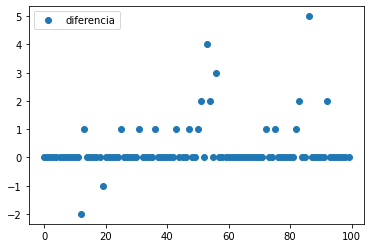

In [85]:
plt.figure(figsize = (15,8))
df_comparacion[['diferencia']].sample(100).reset_index(drop=True).plot(style=['o','rx'])

In [89]:
with open('best_xgboos_model_final.pkl', 'wb') as pickle_model:
    pickle.dump(xgboost_FINAL, pickle_model)